In [1]:
import pandas as pd

df = pd.read_csv("C:\\PythonProjects\\PBL2\\cicids2017_cleaned.csv")
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [2]:
df['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

In [3]:
X = df.drop(['Attack Type'], axis=1)
y = df['Attack Type']

In [4]:
from sklearn.model_selection import train_test_split

# Perform a stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

# Check class distribution
from collections import Counter

print("Train class distribution:", Counter(y_train))
print("Val class distribution:", Counter(y_val))

Training set size: 2016600
Validation set size: 504151
Train class distribution: Counter({'Normal Traffic': 1676045, 'DoS': 154996, 'DDoS': 102411, 'Port Scanning': 72555, 'Brute Force': 7320, 'Web Attacks': 1714, 'Bots': 1559})
Val class distribution: Counter({'Normal Traffic': 419012, 'DoS': 38749, 'DDoS': 25603, 'Port Scanning': 18139, 'Brute Force': 1830, 'Web Attacks': 429, 'Bots': 389})


In [5]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

undersample = RandomUnderSampler(sampling_strategy={  
    'Normal Traffic': 1350000,  # Reduce, but keep enough  
    'DoS': 154996,  # Keep as is  
    'DDoS': 102411,  
    'Port Scanning': 72555,  
    'Brute Force': 7320,  
    'Web Attacks': 1714,  
    'Bots': 1559  
}, random_state=42) 

X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={  
    'Web Attacks': 15000, 
    'Bots': 15000,  
    'Brute Force': 30000  
}, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

In [6]:
print(pd.Series(y_train_resampled).value_counts())

Attack Type
Normal Traffic    1350000
DoS                154996
DDoS               102411
Port Scanning       72555
Brute Force         30000
Bots                15000
Web Attacks         15000
Name: count, dtype: int64


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels (string → integer)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)  # Train labels
y_val_encoded = label_encoder.transform(y_val)

In [9]:
import numpy as np

# Get unique class counts in train and validation sets
train_counts = np.bincount(y_train_encoded)
val_counts = np.bincount(y_val_encoded)

# Print label counts
print("Train Label Counts:")
for label, count in zip(np.unique(y_train_encoded), train_counts):
    print(f"  Class {label}: {count} samples")

print("\nValidation Label Counts:")
for label, count in zip(np.unique(y_val_encoded), val_counts):
    print(f"  Class {label}: {count} samples")

Train Label Counts:
  Class 0: 15000 samples
  Class 1: 30000 samples
  Class 2: 102411 samples
  Class 3: 154996 samples
  Class 4: 1350000 samples
  Class 5: 72555 samples
  Class 6: 15000 samples

Validation Label Counts:
  Class 0: 389 samples
  Class 1: 1830 samples
  Class 2: 25603 samples
  Class 3: 38749 samples
  Class 4: 419012 samples
  Class 5: 18139 samples
  Class 6: 429 samples


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert training data (balanced dataset)
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Convert validation data (original dataset)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

# Create DataLoaders
batch_size = 256 # <-- SET YOUR BATCH SIZE
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN + BiLSTM model
class CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_BiLSTM, self).__init__()

        # 3 CNN Layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout3 = nn.Dropout(0.1)

        # Fully Connected Output Layer
        self.fc = nn.Linear(64 * 2, num_classes)  # BiLSTM is bidirectional (×2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Change to (batch_size, 1, features) for CNN
        
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.relu(self.conv3(x))

        x = x.permute(0, 2, 1)  # Reshape for LSTM (batch, seq_len, features)
        x, _ = self.lstm(x)
        #x = self.dropout3(x)

        x = self.fc(x[:, -1, :])  # Use last time step from BiLSTM
        return x

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_classes = len(label_encoder.classes_)


# Define model, loss, optimizer
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda")

model = CNN_BiLSTM(num_classes).to("cuda")
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.004)

# LR Scheduler: Reduce LR if validation accuracy plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.84, verbose=True)

c:\PythonProjects\PBL2\pbl\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30: 100%|██████████| 6797/6797 [01:01<00:00, 110.28it/s, train_loss=0.807]


Epoch [1/30] → Train Loss: 0.6761, Train Acc: 55.23% | Val Loss: 0.4402, Val Acc: 81.62%
💾 Model saved: nids_v8_weight.pth


Epoch 2/30: 100%|██████████| 6797/6797 [01:02<00:00, 109.49it/s, train_loss=0.352]


Epoch [2/30] → Train Loss: 0.4729, Train Acc: 75.83% | Val Loss: 0.3839, Val Acc: 77.22%
💾 Model saved: nids_v8_weight.pth


Epoch 3/30: 100%|██████████| 6797/6797 [01:03<00:00, 107.67it/s, train_loss=0.588]


Epoch [3/30] → Train Loss: 0.4273, Train Acc: 77.85% | Val Loss: 0.3208, Val Acc: 83.05%
💾 Model saved: nids_v8_weight.pth


Epoch 4/30: 100%|██████████| 6797/6797 [01:01<00:00, 110.45it/s, train_loss=0.346]


Epoch [4/30] → Train Loss: 0.4084, Train Acc: 78.20% | Val Loss: 0.2616, Val Acc: 84.13%
💾 Model saved: nids_v8_weight.pth


Epoch 5/30: 100%|██████████| 6797/6797 [01:03<00:00, 107.13it/s, train_loss=0.786]


Epoch [5/30] → Train Loss: 0.3893, Train Acc: 78.72% | Val Loss: 0.2922, Val Acc: 83.27%
💾 Model saved: nids_v8_weight.pth


Epoch 6/30: 100%|██████████| 6797/6797 [01:03<00:00, 107.02it/s, train_loss=0.499]


Epoch [6/30] → Train Loss: 0.3802, Train Acc: 79.16% | Val Loss: 0.2965, Val Acc: 83.48%
💾 Model saved: nids_v8_weight.pth


Epoch 7/30: 100%|██████████| 6797/6797 [01:01<00:00, 109.75it/s, train_loss=0.176]


Epoch [7/30] → Train Loss: 0.3491, Train Acc: 80.30% | Val Loss: 0.2541, Val Acc: 85.31%
💾 Model saved: nids_v8_weight.pth


Epoch 8/30: 100%|██████████| 6797/6797 [01:00<00:00, 111.45it/s, train_loss=0.257] 


Epoch [8/30] → Train Loss: 0.3106, Train Acc: 81.85% | Val Loss: 0.2042, Val Acc: 86.64%
💾 Model saved: nids_v8_weight.pth


Epoch 9/30: 100%|██████████| 6797/6797 [01:03<00:00, 107.86it/s, train_loss=0.253] 


Epoch [9/30] → Train Loss: 0.2961, Train Acc: 82.19% | Val Loss: 0.1969, Val Acc: 87.25%
💾 Model saved: nids_v8_weight.pth


Epoch 10/30: 100%|██████████| 6797/6797 [01:01<00:00, 111.35it/s, train_loss=0.199] 


Epoch [10/30] → Train Loss: 0.2667, Train Acc: 83.50% | Val Loss: 0.1821, Val Acc: 87.80%
💾 Model saved: nids_v8_weight.pth


Epoch 11/30: 100%|██████████| 6797/6797 [01:01<00:00, 110.43it/s, train_loss=0.291] 


Epoch [11/30] → Train Loss: 0.2494, Train Acc: 84.15% | Val Loss: 0.1951, Val Acc: 87.51%
💾 Model saved: nids_v8_weight.pth


Epoch 12/30: 100%|██████████| 6797/6797 [01:00<00:00, 112.32it/s, train_loss=0.263] 


Epoch [12/30] → Train Loss: 0.2350, Train Acc: 84.80% | Val Loss: 0.2162, Val Acc: 86.30%
💾 Model saved: nids_v8_weight.pth


Epoch 13/30: 100%|██████████| 6797/6797 [01:00<00:00, 112.23it/s, train_loss=0.533] 


Epoch [13/30] → Train Loss: 0.2243, Train Acc: 85.19% | Val Loss: 0.1775, Val Acc: 88.22%
💾 Model saved: nids_v8_weight.pth


Epoch 14/30: 100%|██████████| 6797/6797 [01:01<00:00, 110.86it/s, train_loss=0.415] 


Epoch [14/30] → Train Loss: 0.2179, Train Acc: 85.41% | Val Loss: 0.1737, Val Acc: 87.60%
💾 Model saved: nids_v8_weight.pth


Epoch 15/30: 100%|██████████| 6797/6797 [01:02<00:00, 108.96it/s, train_loss=0.192] 


Epoch [15/30] → Train Loss: 0.2163, Train Acc: 85.48% | Val Loss: 0.1655, Val Acc: 89.04%
💾 Model saved: nids_v8_weight.pth


Epoch 16/30: 100%|██████████| 6797/6797 [01:01<00:00, 111.09it/s, train_loss=0.15]  


Epoch [16/30] → Train Loss: 0.2118, Train Acc: 85.81% | Val Loss: 0.1939, Val Acc: 87.66%
💾 Model saved: nids_v8_weight.pth


Epoch 17/30: 100%|██████████| 6797/6797 [01:02<00:00, 108.04it/s, train_loss=0.368] 


Epoch [17/30] → Train Loss: 0.2104, Train Acc: 85.85% | Val Loss: 0.2460, Val Acc: 84.92%
💾 Model saved: nids_v8_weight.pth


Epoch 18/30: 100%|██████████| 6797/6797 [01:02<00:00, 109.10it/s, train_loss=0.27]  


Epoch [18/30] → Train Loss: 0.2079, Train Acc: 86.01% | Val Loss: 0.1849, Val Acc: 87.75%
💾 Model saved: nids_v8_weight.pth


Epoch 19/30: 100%|██████████| 6797/6797 [01:01<00:00, 111.12it/s, train_loss=0.15]  


Epoch [19/30] → Train Loss: 0.2037, Train Acc: 86.18% | Val Loss: 0.1725, Val Acc: 87.91%
💾 Model saved: nids_v8_weight.pth


Epoch 20/30: 100%|██████████| 6797/6797 [01:01<00:00, 111.32it/s, train_loss=0.159] 


Epoch [20/30] → Train Loss: 0.1923, Train Acc: 86.76% | Val Loss: 0.1554, Val Acc: 88.26%
💾 Model saved: nids_v8_weight.pth


Epoch 21/30: 100%|██████████| 6797/6797 [01:02<00:00, 109.49it/s, train_loss=0.149] 


Epoch [21/30] → Train Loss: 0.1858, Train Acc: 86.97% | Val Loss: 0.1451, Val Acc: 89.65%
💾 Model saved: nids_v8_weight.pth


Epoch 22/30: 100%|██████████| 6797/6797 [00:53<00:00, 127.20it/s, train_loss=0.163] 


Epoch [22/30] → Train Loss: 0.1842, Train Acc: 87.03% | Val Loss: 0.1419, Val Acc: 90.36%
💾 Model saved: nids_v8_weight.pth


Epoch 23/30: 100%|██████████| 6797/6797 [00:57<00:00, 117.42it/s, train_loss=0.223] 


Epoch [23/30] → Train Loss: 0.1835, Train Acc: 87.06% | Val Loss: 0.1514, Val Acc: 89.16%
💾 Model saved: nids_v8_weight.pth


Epoch 24/30: 100%|██████████| 6797/6797 [01:01<00:00, 110.63it/s, train_loss=0.136] 


Epoch [24/30] → Train Loss: 0.1816, Train Acc: 87.19% | Val Loss: 0.1529, Val Acc: 88.61%
💾 Model saved: nids_v8_weight.pth


Epoch 25/30: 100%|██████████| 6797/6797 [01:01<00:00, 110.00it/s, train_loss=0.144] 


Epoch [25/30] → Train Loss: 0.1991, Train Acc: 85.98% | Val Loss: 0.1506, Val Acc: 88.47%
💾 Model saved: nids_v8_weight.pth


Epoch 26/30: 100%|██████████| 6797/6797 [01:01<00:00, 110.00it/s, train_loss=0.193] 


Epoch [26/30] → Train Loss: 0.1803, Train Acc: 87.26% | Val Loss: 0.1455, Val Acc: 89.39%
💾 Model saved: nids_v8_weight.pth


Epoch 27/30: 100%|██████████| 6797/6797 [01:01<00:00, 111.23it/s, train_loss=0.139] 


Epoch [27/30] → Train Loss: 0.1710, Train Acc: 87.70% | Val Loss: 0.1496, Val Acc: 89.22%
💾 Model saved: nids_v8_weight.pth


Epoch 28/30: 100%|██████████| 6797/6797 [01:00<00:00, 111.51it/s, train_loss=0.117] 


Epoch [28/30] → Train Loss: 0.1694, Train Acc: 87.79% | Val Loss: 0.1710, Val Acc: 88.65%
💾 Model saved: nids_v8_weight.pth


Epoch 29/30: 100%|██████████| 6797/6797 [01:02<00:00, 109.57it/s, train_loss=0.0793]


Epoch [29/30] → Train Loss: 0.1666, Train Acc: 87.89% | Val Loss: 0.1395, Val Acc: 88.18%
💾 Model saved: nids_v8_weight.pth


Epoch 30/30: 100%|██████████| 6797/6797 [01:01<00:00, 110.25it/s, train_loss=0.127] 


Epoch [30/30] → Train Loss: 0.1633, Train Acc: 88.12% | Val Loss: 0.1291, Val Acc: 90.40%
💾 Model saved: nids_v8_weight.pth
🏆 Best Validation Accuracy: 90.40%


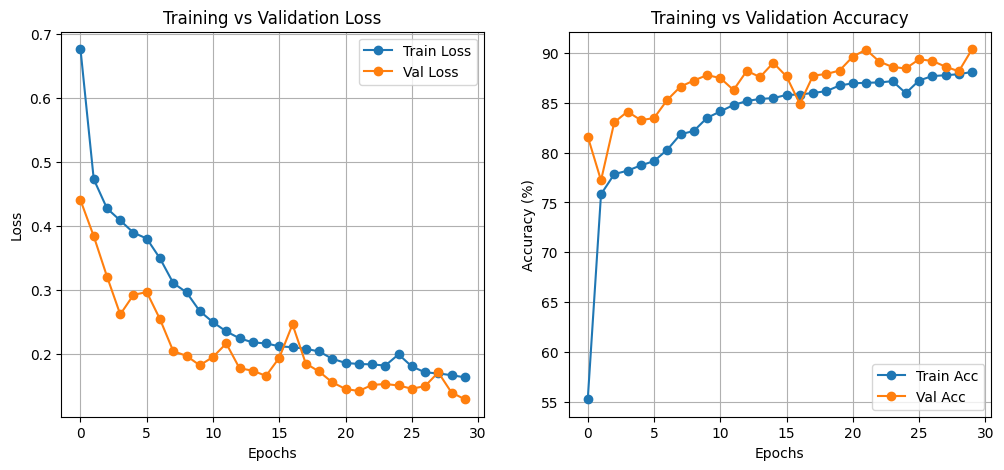

In [13]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Early Stopping
patience = 15
best_val_acc = 0
epochs_no_improve = 0

num_epochs = 30  # Adjustable

# Store loss & accuracy for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    # Training Loop with Progress Bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

        # Update progress bar
        loop.set_postfix(train_loss=loss.item())

    train_acc = train_correct / train_total * 100
    avg_train_loss = train_loss / len(train_loader)

    # Store training metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation Step
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_acc = val_correct / val_total * 100
    avg_val_loss = val_loss / len(val_loader)

    # Store validation metrics
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Print Epoch Summary
    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save model weights
    torch.save(model.state_dict(), f"nids_v8_weight.pth")
    print(f"💾 Model saved: nids_v8_weight.pth")

    # Update LR if validation accuracy plateaus
    scheduler.step(val_acc)

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("⏹️ Early stopping triggered! Stopping training.")
        break

print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")

# Plot Loss and Accuracy Graphs
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc", marker="o")
plt.plot(val_accuracies, label="Val Acc", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()

plt.show()


Epoch 31/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.10it/s, train_loss=0.321] 


Epoch [31/50] → Train Loss: 0.1615, Train Acc: 88.13% | Val Loss: 0.1707, Val Acc: 89.37%
💾 Model saved: nids_v8_weight.pth


Epoch 32/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.79it/s, train_loss=0.424] 


Epoch [32/50] → Train Loss: 0.1598, Train Acc: 88.15% | Val Loss: 0.1195, Val Acc: 90.95%
💾 Model saved: nids_v8_weight.pth


Epoch 33/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.17it/s, train_loss=0.111] 


Epoch [33/50] → Train Loss: 0.1607, Train Acc: 88.26% | Val Loss: 0.1268, Val Acc: 90.46%
💾 Model saved: nids_v8_weight.pth


Epoch 34/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.18it/s, train_loss=0.266] 


Epoch [34/50] → Train Loss: 0.1600, Train Acc: 88.22% | Val Loss: 0.1475, Val Acc: 89.28%
💾 Model saved: nids_v8_weight.pth


Epoch 35/50: 100%|██████████| 6797/6797 [01:01<00:00, 111.20it/s, train_loss=0.0551]


Epoch [35/50] → Train Loss: 0.1580, Train Acc: 88.46% | Val Loss: 0.1345, Val Acc: 90.45%
💾 Model saved: nids_v8_weight.pth


Epoch 36/50: 100%|██████████| 6797/6797 [01:01<00:00, 111.12it/s, train_loss=0.155] 


Epoch [36/50] → Train Loss: 0.1565, Train Acc: 88.44% | Val Loss: 0.1302, Val Acc: 89.72%
💾 Model saved: nids_v8_weight.pth


Epoch 37/50: 100%|██████████| 6797/6797 [01:01<00:00, 109.88it/s, train_loss=0.131] 


Epoch [37/50] → Train Loss: 0.1501, Train Acc: 88.71% | Val Loss: 0.1199, Val Acc: 90.85%
💾 Model saved: nids_v8_weight.pth


Epoch 38/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.66it/s, train_loss=0.243] 


Epoch [38/50] → Train Loss: 0.1468, Train Acc: 88.92% | Val Loss: 0.1227, Val Acc: 91.17%
💾 Model saved: nids_v8_weight.pth


Epoch 39/50: 100%|██████████| 6797/6797 [01:01<00:00, 111.28it/s, train_loss=0.0944]


Epoch [39/50] → Train Loss: 0.1464, Train Acc: 88.93% | Val Loss: 0.1186, Val Acc: 91.57%
💾 Model saved: nids_v8_weight.pth


Epoch 40/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.57it/s, train_loss=0.159] 


Epoch [40/50] → Train Loss: 0.1440, Train Acc: 88.94% | Val Loss: 0.1588, Val Acc: 88.86%
💾 Model saved: nids_v8_weight.pth


Epoch 41/50: 100%|██████████| 6797/6797 [01:07<00:00, 100.99it/s, train_loss=0.104] 


Epoch [41/50] → Train Loss: 0.1444, Train Acc: 89.01% | Val Loss: 0.1314, Val Acc: 90.67%
💾 Model saved: nids_v8_weight.pth


Epoch 42/50: 100%|██████████| 6797/6797 [01:06<00:00, 102.33it/s, train_loss=0.0814]


Epoch [42/50] → Train Loss: 0.1423, Train Acc: 89.02% | Val Loss: 0.1105, Val Acc: 91.54%
💾 Model saved: nids_v8_weight.pth


Epoch 43/50: 100%|██████████| 6797/6797 [01:05<00:00, 103.47it/s, train_loss=0.29]  


Epoch [43/50] → Train Loss: 0.1470, Train Acc: 88.86% | Val Loss: 0.1216, Val Acc: 91.15%
💾 Model saved: nids_v8_weight.pth


Epoch 44/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.75it/s, train_loss=0.126] 


Epoch [44/50] → Train Loss: 0.1390, Train Acc: 89.29% | Val Loss: 0.1112, Val Acc: 91.71%
💾 Model saved: nids_v8_weight.pth


Epoch 45/50: 100%|██████████| 6797/6797 [00:53<00:00, 126.95it/s, train_loss=0.078] 


Epoch [45/50] → Train Loss: 0.1358, Train Acc: 89.39% | Val Loss: 0.1117, Val Acc: 91.52%
💾 Model saved: nids_v8_weight.pth


Epoch 46/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.69it/s, train_loss=0.221] 


Epoch [46/50] → Train Loss: 0.1329, Train Acc: 89.44% | Val Loss: 0.1224, Val Acc: 90.78%
💾 Model saved: nids_v8_weight.pth


Epoch 47/50: 100%|██████████| 6797/6797 [01:00<00:00, 111.89it/s, train_loss=0.265] 


Epoch [47/50] → Train Loss: 0.1328, Train Acc: 89.55% | Val Loss: 0.1106, Val Acc: 91.45%
💾 Model saved: nids_v8_weight.pth


Epoch 48/50: 100%|██████████| 6797/6797 [01:01<00:00, 111.28it/s, train_loss=0.0833]


Epoch [48/50] → Train Loss: 0.1316, Train Acc: 89.58% | Val Loss: 0.1125, Val Acc: 91.13%
💾 Model saved: nids_v8_weight.pth


Epoch 49/50: 100%|██████████| 6797/6797 [01:01<00:00, 110.74it/s, train_loss=0.0622]


Epoch [49/50] → Train Loss: 0.1274, Train Acc: 89.80% | Val Loss: 0.1151, Val Acc: 91.33%
💾 Model saved: nids_v8_weight.pth


Epoch 50/50: 100%|██████████| 6797/6797 [01:01<00:00, 111.32it/s, train_loss=0.0817]


Epoch [50/50] → Train Loss: 0.1282, Train Acc: 89.74% | Val Loss: 0.1371, Val Acc: 89.58%
💾 Model saved: nids_v8_weight.pth
🏆 Best Validation Accuracy: 91.71%


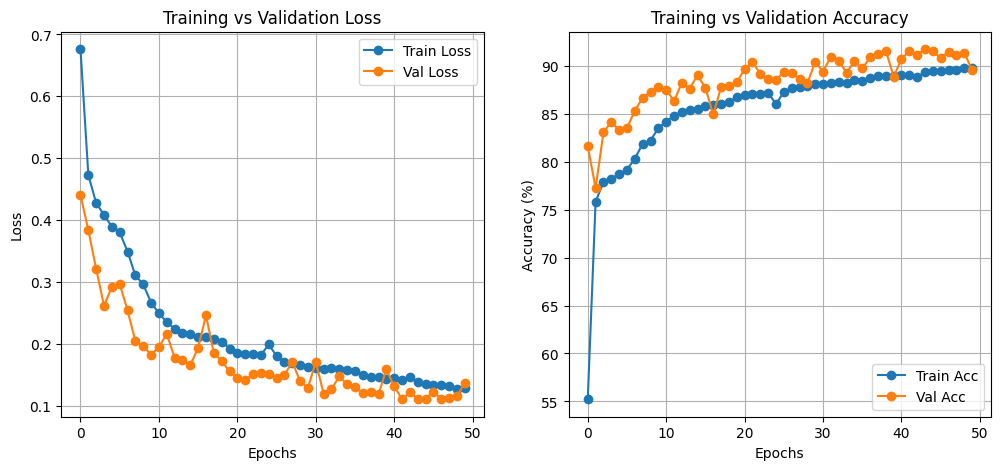

In [19]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Early Stopping
patience = 15
best_val_acc = 0
epochs_no_improve = 0

num_epochs = 50  # Adjustable

for epoch in range(30, num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    # Training Loop with Progress Bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

        # Update progress bar
        loop.set_postfix(train_loss=loss.item())

    train_acc = train_correct / train_total * 100
    avg_train_loss = train_loss / len(train_loader)

    # Store training metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation Step
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_acc = val_correct / val_total * 100
    avg_val_loss = val_loss / len(val_loader)

    # Store validation metrics
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Print Epoch Summary
    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save model weights
    torch.save(model.state_dict(), f"nids_v8_weight.pth")
    print(f"💾 Model saved: nids_v8_weight.pth")

    # Update LR if validation accuracy plateaus
    scheduler.step(val_acc)

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("⏹️ Early stopping triggered! Stopping training.")
        break

print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")

# Plot Loss and Accuracy Graphs
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc", marker="o")
plt.plot(val_accuracies, label="Val Acc", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()

plt.show()


In [20]:
torch.save(model, "nids_v8.pth")

In [21]:
import numpy as np

y_true = []
y_scores = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
        outputs = model(X_batch)  # Raw model outputs
        probs = torch.softmax(outputs, dim=1)  # Convert to probabilities

        y_true.extend(y_batch.cpu().numpy())  # True labels
        y_scores.extend(probs.cpu().numpy())  # Probabilities for each class


['Bots' 'Brute Force' 'DDoS' 'DoS' 'Normal Traffic' 'Port Scanning'
 'Web Attacks']


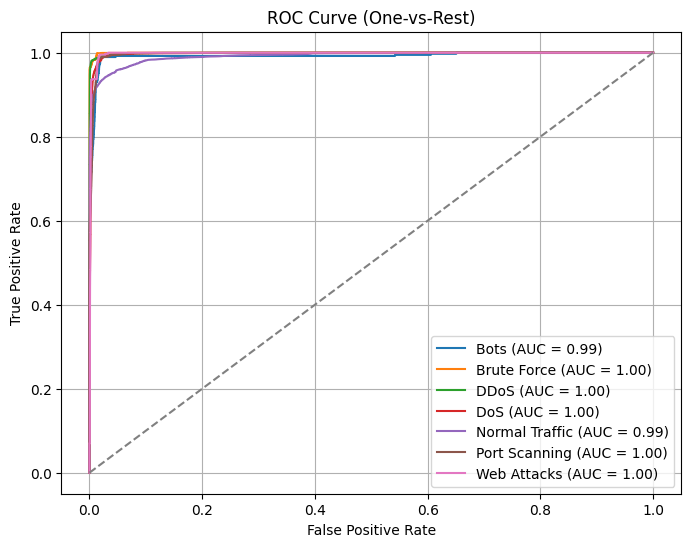

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class (One-vs-Rest)
n_classes = len(set(y_true))  # Number of classes
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))  # Convert to binary format

class_names = label_encoder.classes_
print(class_names)

# Compute ROC Curve & AUC for each class
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid()
plt.show()


c:\PythonProjects\PBL2\pbl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


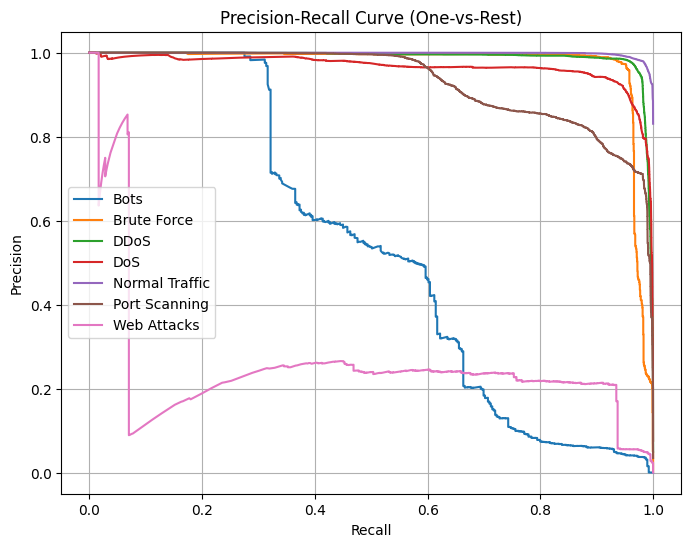

In [23]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
    plt.plot(recall, precision, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.legend()
plt.grid()
plt.show()


In [24]:
torch.save(model.state_dict(), "nids_v8_modelState.pth")